## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data folder

In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/fashion_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving Fragmentation issue of memory

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [4]:
import struct
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import time

## Autoencoder class

In [5]:
class PCA_Autoencoder(nn.Module):
    def __init__(self, n_components=None):
        super(PCA_Autoencoder, self).__init__()
        self.n_components = n_components
        self.eigenvectors = None
        self.mean = None

    def fit(self, data):
        # Flatten the 28x28 images to a 784-dimensional vectors
        data = data.reshape(data.shape[0], -1)  # Shape: (num_samples, 784)

        # Centering the data
        self.mean = np.mean(data, axis=0)
        centered_data = data - self.mean

        # Calculating the covariance matrix
        covariance_matrix = np.cov(centered_data, rowvar=False)

        # Computing eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Sorting eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Keep only the top n_components eigenvectors
        if self.n_components:
            eigenvectors = eigenvectors[:, :self.n_components]

        # Store the eigenvectors as a torch tensor
        self.eigenvectors = torch.tensor(eigenvectors, dtype=torch.float32)
        self.mean = torch.tensor(self.mean, dtype=torch.float32)

    def encode(self, data):
        # Flatten images and center data
        data = data.reshape(data.shape[0], -1)
        centered_data = torch.tensor(data, dtype=torch.float32) - self.mean
        # Project data onto the eigenvectors
        return torch.matmul(centered_data, self.eigenvectors).numpy()

    def forward(self, encoded_data):
        if self.eigenvectors is None:
            raise ValueError("PCA model is not fitted yet.")
        # Reconstruct data by reversing the projection
        reconstructed_data = torch.matmul(encoded_data, self.eigenvectors.T) + self.mean
        # Reshape back to the original 28x28 image shape
        return reconstructed_data.view(-1, 28, 28).numpy()

## Functions to read the dataset

In [6]:
def read_idx3_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and dimensions of the dataset
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read the rest of the data
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Reshape to [num_images, rows, cols]
        images = images.reshape(num_images, rows, cols)

    return images

def read_idx1_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

## Data reading and preprocessing

In [7]:
train_images = read_idx3_ubyte("/content/fashion_mnist/train-images-idx3-ubyte")
test_images = read_idx3_ubyte("/content/fashion_mnist/t10k-images-idx3-ubyte")
train_labels = read_idx1_ubyte("/content/fashion_mnist/train-labels-idx1-ubyte")
test_labels = read_idx1_ubyte("/content/fashion_mnist/t10k-labels-idx1-ubyte")

# Taking the first 50k images as train set and rest 10k images as val set
train_images, val_images = train_images[:50000], train_images[50000:60000]
train_labels, val_labels = train_labels[:50000], train_labels[50000:60000]

# Converting all the images to the range of [0, 1]
train_images, test_images, val_images = train_images / 255, test_images / 255, val_images / 255
print("Train, test and val data normalised.")

Train, test and val data normalised.


## Function to calculate MSE

In [8]:
def calculate_recon_loss(original_images, reconstructed_images):
    num_images = original_images.shape[0]
    original_flat = original_images.reshape(num_images, -1)
    reconstructed_flat = reconstructed_images.reshape(num_images, -1)
    mse = np.mean((original_flat - reconstructed_flat) ** 2)
    return mse

## Training PCA Autoencoder

For 1 components, reconstruction loss = 0.06167887362974608, time taken = 1.6789624691009521 s
For 2 components, reconstruction loss = 0.04632823100896089, time taken = 1.4572348594665527 s
For 3 components, reconstruction loss = 0.04107840736409162, time taken = 1.4358258247375488 s
For 4 components, reconstruction loss = 0.03689202713957585, time taken = 1.5067975521087646 s
For 5 components, reconstruction loss = 0.03352175219253132, time taken = 2.7611122131347656 s
For 6 components, reconstruction loss = 0.030406582214854757, time taken = 2.0863535404205322 s
For 7 components, reconstruction loss = 0.02833464000201378, time taken = 1.887328863143921 s
For 8 components, reconstruction loss = 0.026729455751135747, time taken = 1.5562448501586914 s
For 9 components, reconstruction loss = 0.025567895695648536, time taken = 1.4328620433807373 s
For 10 components, reconstruction loss = 0.02443484204933024, time taken = 1.4507725238800049 s
For 11 components, reconstruction loss = 0.0235

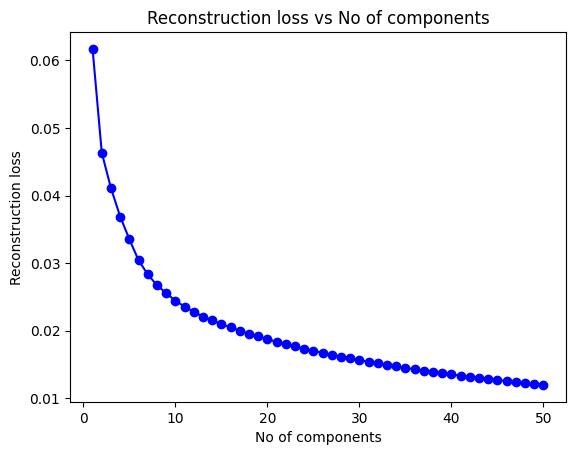

In [9]:
# Instantiate PCA Autoencoder
pca_autoencoder = PCA_Autoencoder()

recon_loss_arr = list()

for n_components in range(1, 51):
    pca_autoencoder = PCA_Autoencoder(n_components)
    start_time = time.time()
    pca_autoencoder.fit(train_images)
    encoded_data = pca_autoencoder.encode(val_images)
    reconstructed_images = pca_autoencoder.forward(torch.tensor(encoded_data, dtype=torch.float32))
    end_time = time.time()
    recon_loss = calculate_recon_loss(val_images, reconstructed_images)
    recon_loss_arr.append(recon_loss)
    print(f"For {n_components} components, reconstruction loss = {recon_loss}, time taken = {end_time - start_time} s")

# Reconstruction loss vs number of principle components graph
plt.plot(np.arange(1, 51), recon_loss_arr, color="blue", marker="o")
plt.title("Reconstruction loss vs No of components")
plt.xlabel("No of components")
plt.ylabel("Reconstruction loss")
plt.show()
# plt.savefig("/content/drive/MyDrive/smai_a4/figures/pca_autoencoder/recon_loss_vs_components.png")
plt.close()

## Selecting the optimal number of dimensions after analysing the elbow plot

In [10]:
k_optimal = 7

## Visualising the reconstructed images using k_optimal components

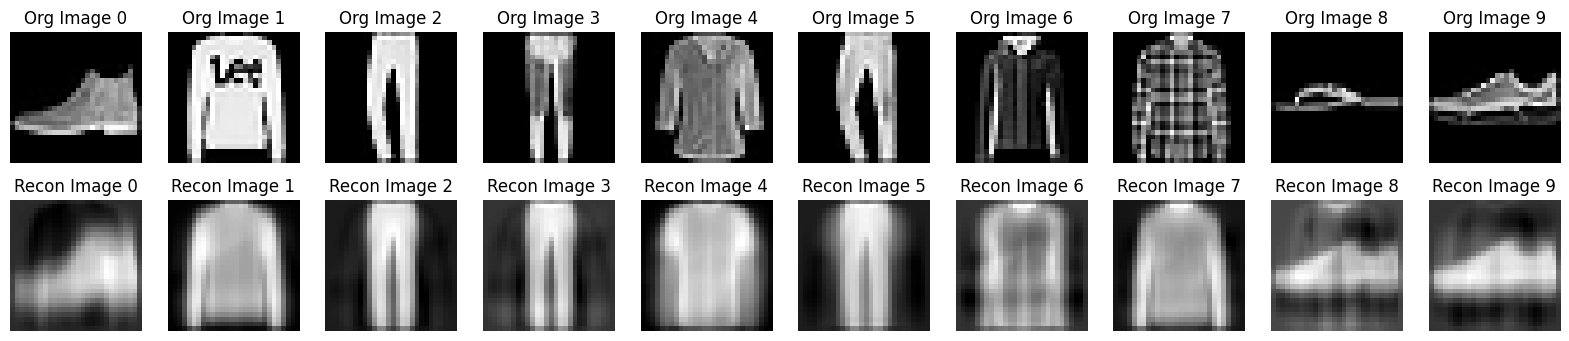

In [11]:
pca_autoencoder = PCA_Autoencoder(k_optimal)
pca_autoencoder.fit(train_images)
encoded_data = pca_autoencoder.encode(test_images)
reconstructed_images = pca_autoencoder.forward(torch.tensor(encoded_data, dtype=torch.float32))

# Visualization of original and reconstructed images
num_images = 10
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Original images
    plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images[i], cmap="gray")
    plt.title(f"Org Image {i}")
    plt.axis("off")

    # Reconstructed images
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i], cmap="gray")
    plt.title(f"Recon Image {i}")
    plt.axis("off")

plt.show()
# plt.savefig("/content/drive/MyDrive/smai_a4/figures/pca_autoencoder/org_vs_recon_img_comparison.png")
plt.close()

> We can see that taking 50 components brings down the reconstruction error for PCA autoencoder to the lowest among the 3 models but we can see that after dimension = 7 there is a minimal change with the increase of each dimension so we will take 7 as the optimal dimension and at dim=7 the reconstruction is very hazy and hence among the 3 models, MLP Autoencoder works the best at reconstruction.